In [1]:
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import pymc as pm
import arviz as az

Here's a basic implementation of the Metropolis algorithm from [Wikipedia](https://en.wikipedia.org/wiki/Metropolis%E2%80%93Hastings_algorithm#Description).

In [2]:
def target(x):
    return stats.norm.pdf(x)

def proposal(x):
    return np.random.normal(x)

def metropolis(x):
    x_ = proposal(x)
    if np.random.rand() <= target(x_) / target(x):
        return x_
    return x

def mcmc(iters, x):
    result = [x]
    for _ in range(iters - 1):
        x = metropolis(x)
        result.append(x)
    return result

states = mcmc(10000, 1)
states = states[9000:]

mu = np.mean(states)

print(f'mu: {mu:.2f}')

mu: -0.02


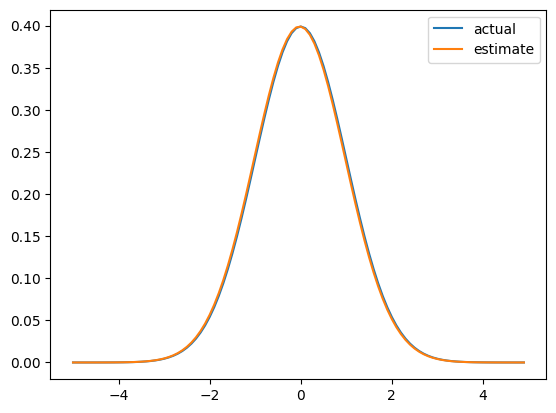

In [3]:
x = np.arange(-5, 5, 0.1)
plt.plot(x, stats.norm.pdf(x), label='actual')
plt.plot(x, stats.norm.pdf(x, mu), label='estimate')
plt.legend()
plt.show()

Now, let's try to estimate the mean `mu` and standard deviation `sigma` of some randomly generated data.

In this example, we'll use the following parameters:

| Parameter | Actual | Guess | Prior    |
|-----------|--------|-------|----------|
| mu        | 8.5    | 10    | U(5, 15) |
| sigma     | 2.5    | 2     | U(1, 3)  |

In [4]:
def prior(mu, sigma):
    return stats.uniform.pdf(mu, 5, 15) * stats.uniform.pdf(sigma, 1, 3)

def likelihood(data, mu, sigma):
    return np.prod(stats.norm.pdf(data, mu, sigma))

def posterior(data, mu, sigma):
    return likelihood(data, mu, sigma) * prior(mu, sigma)

def proposal(mu, sigma):
    return np.random.normal(mu), np.random.normal(sigma)

def metropolis(data, mu, sigma):
    mu_, sigma_ = proposal(mu, sigma)
    if np.random.rand() <= posterior(data, mu_, sigma_) / posterior(data, mu, sigma):
        return mu_, sigma_
    return mu, sigma

def mcmc(iters, data, mu, sigma):
    result = [(mu, sigma)]
    for _ in range(iters - 1):
        mu, sigma = metropolis(data, mu, sigma)
        result.append((mu, sigma))
    return result

data = np.random.normal(8.5, 2.5, 1000)

states = mcmc(10000, data, 10, 2)
states = states[9000:]

mu, sigma = np.mean(states, axis=0)

<ipython-input-4-716fde5d4c49>:15: RuntimeWarning: invalid value encountered in scalar divide
  if np.random.rand() <= posterior(data, mu_, sigma_) / posterior(data, mu, sigma):


Oh no. A runtime error?

In [5]:
print(f'mu: {mu:.1f}')
print(f'sigma: {sigma:.1f}')

mu: 10.0
sigma: 2.0


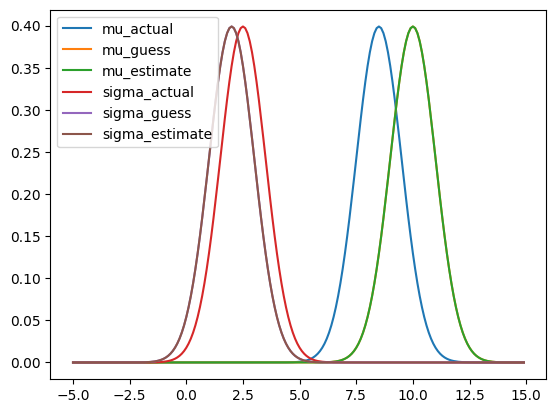

In [6]:
x = np.arange(-5, 15, 0.1)
plt.plot(x, stats.norm.pdf(x, 8.5), label='mu_actual')
plt.plot(x, stats.norm.pdf(x, 10), label='mu_guess')
plt.plot(x, stats.norm.pdf(x, mu), label='mu_estimate')
plt.plot(x, stats.norm.pdf(x, 2.5), label='sigma_actual')
plt.plot(x, stats.norm.pdf(x, 2), label='sigma_guess')
plt.plot(x, stats.norm.pdf(x, sigma), label='sigma_estimate')
plt.legend()
plt.show()

So, what happened?

The `estimate` curves are overlapping the `guess` curves.

This is because `metropolis` never accepts the `proposal` values because the `likelihood` (and thus `posterior`) always evaluate to `0`.

In [7]:
print(f'prior: {prior(10, 2):.2f}')
print(f'likelihood: {likelihood(data, 10, 2):.2f}')
print(f'posterior: {posterior(data, 10, 2):.2f}')

prior: 0.02
likelihood: 0.00
posterior: 0.00


This is because the product of many values `x` such that 0 <= `x` <= 1 is `0`.

This issue is called [arithmetic underflow](https://en.wikipedia.org/wiki/Arithmetic_underflow), and the runtime error from earlier is a good hint that we have underflow.

We can address this issue by using log-probabilities.

In [8]:
def log_prior(mu, sigma):
    return stats.uniform.logpdf(mu, 5, 15) + stats.uniform.logpdf(sigma, 1, 3)

def log_likelihood(data, mu, sigma):
    return np.sum(stats.norm.logpdf(data, mu, sigma))

def log_posterior(data, mu, sigma):
    return log_likelihood(data, mu, sigma) + log_prior(mu, sigma)

def proposal(mu, sigma):
    return np.random.normal(mu), np.random.normal(sigma)

def metropolis(data, mu, sigma):
    mu_, sigma_ = proposal(mu, sigma)
    if np.random.rand() <= log_posterior(data, mu_, sigma_) - log_posterior(data, mu, sigma):
        return mu_, sigma_
    return mu, sigma

def mcmc(iters, data, mu, sigma):
    result = [(mu, sigma)]
    for _ in range(iters - 1):
        mu, sigma = metropolis(data, mu, sigma)
        result.append((mu, sigma))
    return result

data = np.random.normal(8.5, 2.5, 1000)

states = mcmc(10000, data, 10, 2)
states = states[9000:]

mu, sigma = np.mean(states, axis=0)

print(f'mu: {mu:.1f}')
print(f'sigma: {sigma:.1f}')

mu: 8.5
sigma: 2.5


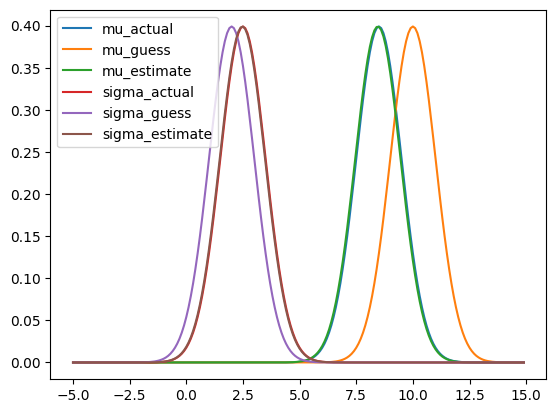

In [9]:
x = np.arange(-5, 15, 0.1)
plt.plot(x, stats.norm.pdf(x, 8.5), label='mu_actual')
plt.plot(x, stats.norm.pdf(x, 10), label='mu_guess')
plt.plot(x, stats.norm.pdf(x, mu), label='mu_estimate')
plt.plot(x, stats.norm.pdf(x, 2.5), label='sigma_actual')
plt.plot(x, stats.norm.pdf(x, 2), label='sigma_guess')
plt.plot(x, stats.norm.pdf(x, sigma), label='sigma_estimate')
plt.legend()
plt.show()

Now, the `estimate` curves are overlapping the `actual` curves. And that's close enough for me.

Here's what a similar analysis would look like using `pymc`.

Just note that [there's a lot going on in the background](https://github.com/pymc-devs/pymc) that we're not seeing.

In [10]:
with pm.Model() as model:
    mu = pm.Uniform('mu', lower=5, upper=15)
    sigma = pm.Uniform('sigma', lower=1, upper=3)
    likelihood = pm.Normal('likelihood', mu=mu, sigma=sigma, observed=data)
    trace = pm.sample(1000, tune=9000, chains=4, step=pm.Metropolis())

/usr/local/lib/python3.10/dist-packages/arviz/utils.py:184: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  numba_fn = numba.jit(**self.kwargs)(self.function)
ERROR:pymc.stats.convergence:The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


In [11]:
pm.summary(trace)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu,8.429,0.077,8.264,8.547,0.007,0.005,126.0,105.0,1.04
sigma,2.466,0.056,2.365,2.567,0.002,0.002,538.0,480.0,1.01


/usr/local/lib/python3.10/dist-packages/arviz/utils.py:184: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  numba_fn = numba.jit(**self.kwargs)(self.function)


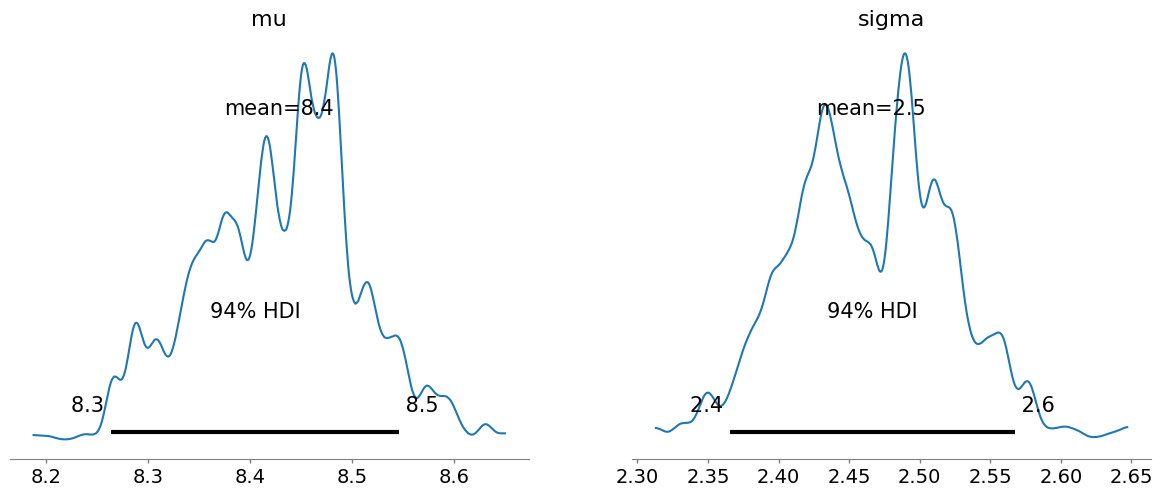

In [12]:
az.plot_posterior(trace)
plt.show()